In [1]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.

Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None


SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools


StoreType - differentiates between 4 different store models: a, b, c, d


Assortment - describes an assortment level: a = basic, b = extra, c = extended


CompetitionDistance - distance in meters to the nearest competitor store


CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened


Promo - indicates whether a store is running a promo on that day


Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating


Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2


PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [46]:
large = 26
med = 22
small = 18
params = {'axes.titlesize': med,
          'legend.fontsize': med,
          'figure.figsize': (med, small),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': med}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

### Data Reading

In [30]:
df_train = pd.read_csv('./data/rossmann-store-sales/train.csv',
                       parse_dates=["Date"])

df_test = pd.read_csv("./data/rossmann-store-sales/test.csv",
                      parse_dates=["Date"])

df_store = pd.read_csv("./data/rossmann-store-sales/store.csv")

In [31]:
df_train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [32]:
df_test.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [33]:
df_store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [34]:
df_train.shape

(1017209, 9)

In [35]:
df_test.shape

(41088, 8)

In [36]:
df_store.shape

(1115, 10)

In [38]:
np.unique(df_train.DayOfWeek)

array([1, 2, 3, 4, 5, 6, 7])

In [42]:
np.unique(df_test.Date)

array(['2015-08-01T00:00:00.000000000', '2015-08-02T00:00:00.000000000',
       '2015-08-03T00:00:00.000000000', '2015-08-04T00:00:00.000000000',
       '2015-08-05T00:00:00.000000000', '2015-08-06T00:00:00.000000000',
       '2015-08-07T00:00:00.000000000', '2015-08-08T00:00:00.000000000',
       '2015-08-09T00:00:00.000000000', '2015-08-10T00:00:00.000000000',
       '2015-08-11T00:00:00.000000000', '2015-08-12T00:00:00.000000000',
       '2015-08-13T00:00:00.000000000', '2015-08-14T00:00:00.000000000',
       '2015-08-15T00:00:00.000000000', '2015-08-16T00:00:00.000000000',
       '2015-08-17T00:00:00.000000000', '2015-08-18T00:00:00.000000000',
       '2015-08-19T00:00:00.000000000', '2015-08-20T00:00:00.000000000',
       '2015-08-21T00:00:00.000000000', '2015-08-22T00:00:00.000000000',
       '2015-08-23T00:00:00.000000000', '2015-08-24T00:00:00.000000000',
       '2015-08-25T00:00:00.000000000', '2015-08-26T00:00:00.000000000',
       '2015-08-27T00:00:00.000000000', '2015-08-28

In [61]:
df_train['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

### Exploratory Analysis 

In [47]:
df_train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [83]:
df_train['Year'] = df_train.Date.dt.year
df_train['Month'] = df_train.Date.dt.month
df_train['Day'] = df_train.Date.dt.day
df_train['WeekOfYear'] = df_train.Date.dt.weekofyear

In [51]:
df_train['log_sales'] = np.log1p(df_train['Sales'])

#### Visualize covariates Open, Promo, StateHoliday, SchoolHoliday

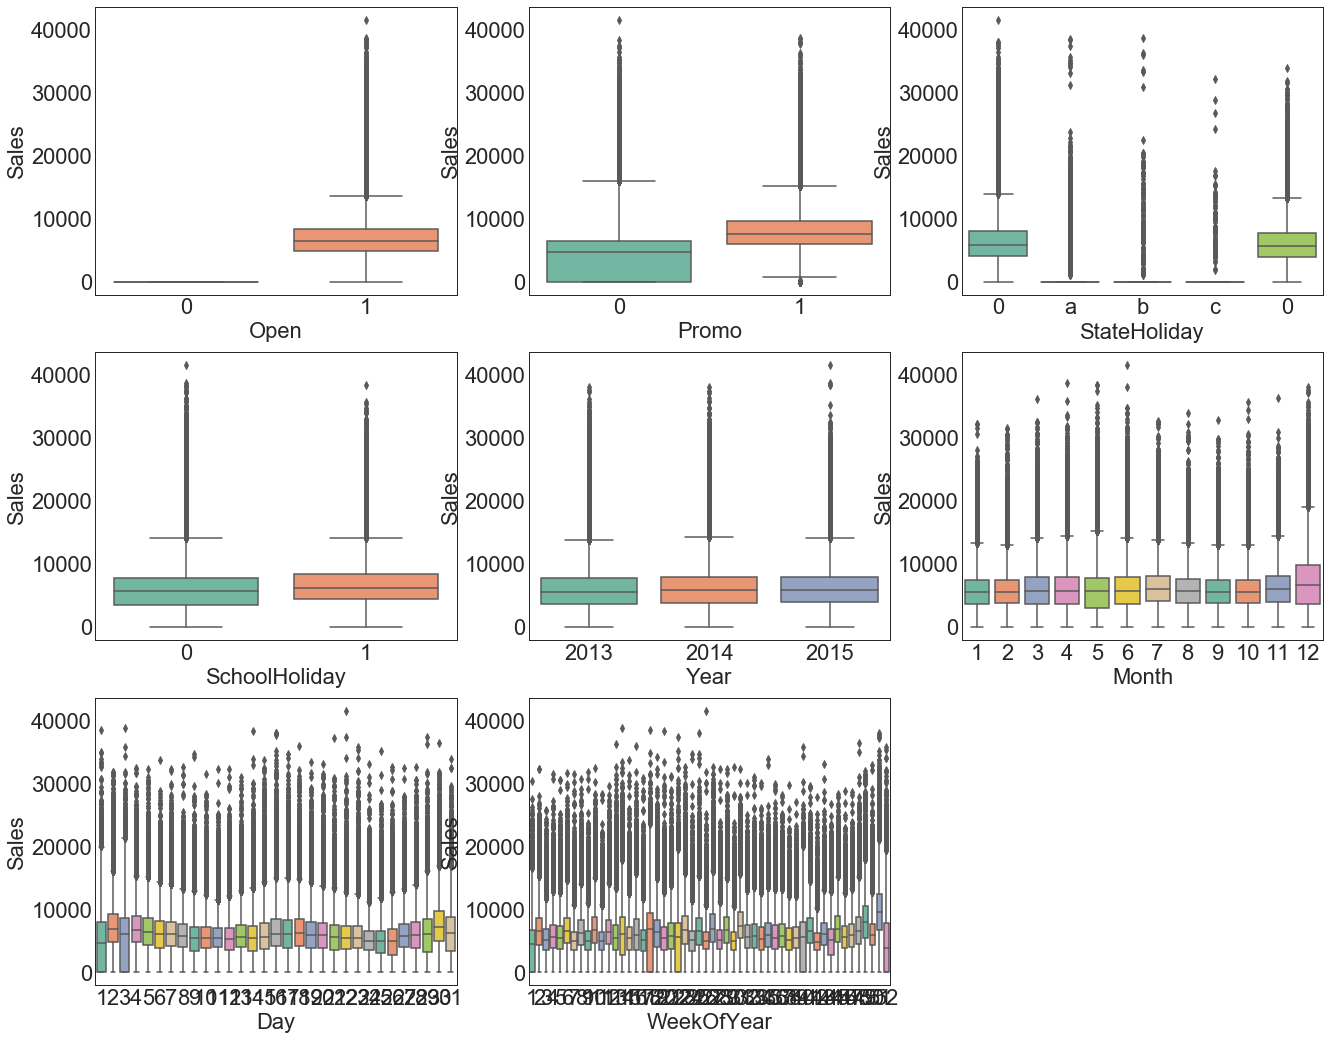

In [85]:
covariates = ['Open','Promo','StateHoliday','SchoolHoliday','Year',
             'Month','Day','WeekOfYear']

for index, c in enumerate(covariates):
    plt.subplot(3,3,index+1)
    sns.boxplot(x=c,
                y='Sales',
                data=df_train,
                palette="Set2")


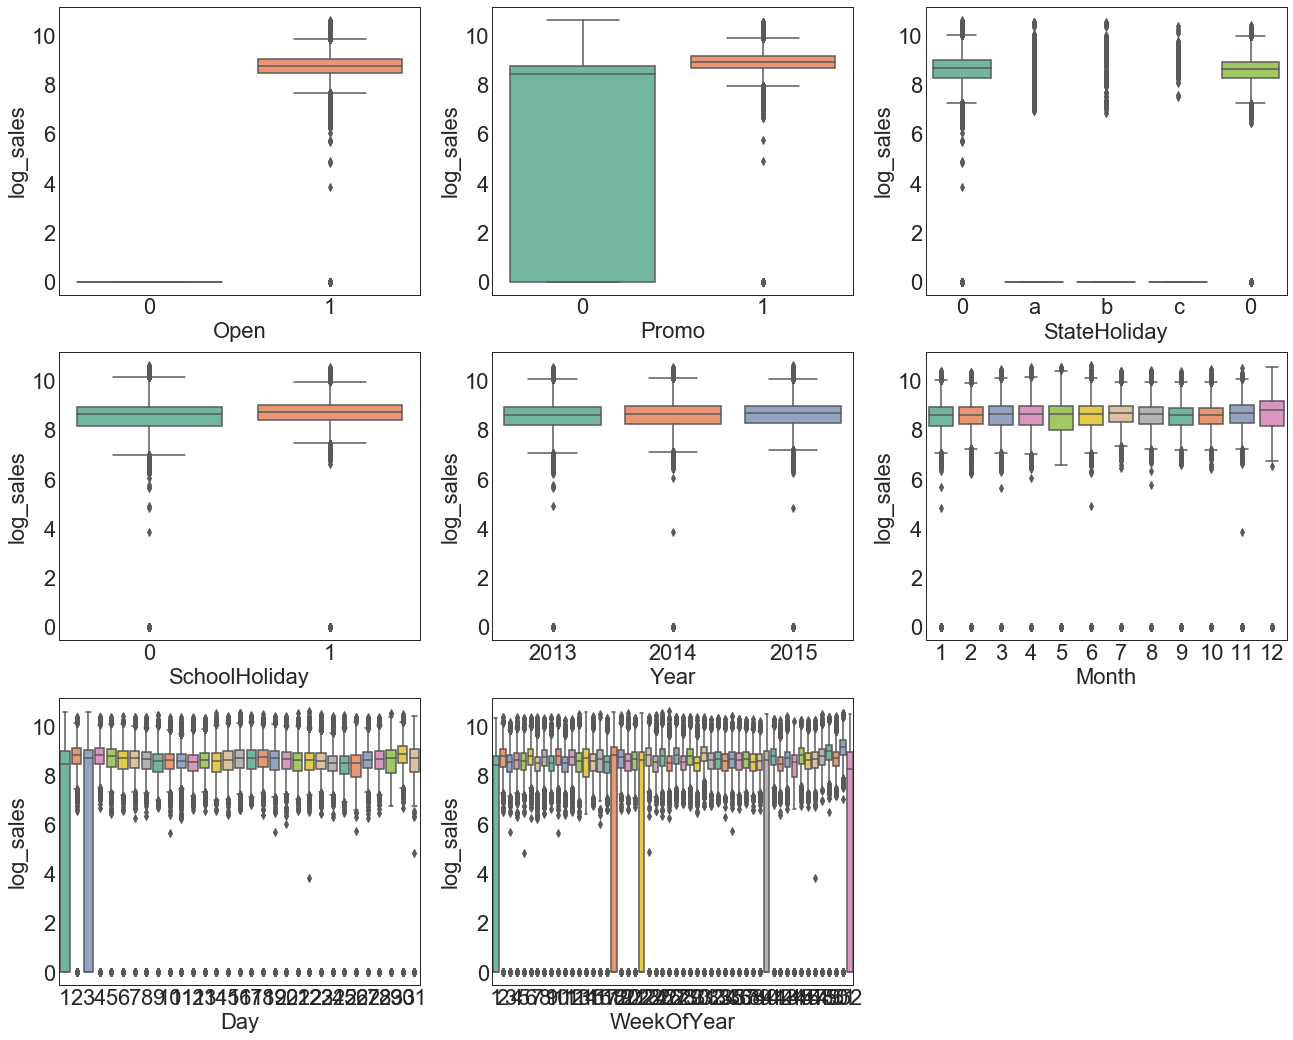

In [86]:
covariates = ['Open','Promo','StateHoliday','SchoolHoliday','Year',
             'Month','Day','WeekOfYear']

for index, c in enumerate(covariates):
    plt.subplot(3,3,index+1)
    sns.boxplot(x=c,
                y='log_sales',
                data=df_train,
                palette="Set2")

#### Visualize the overall trend of the sales


(0, 20)

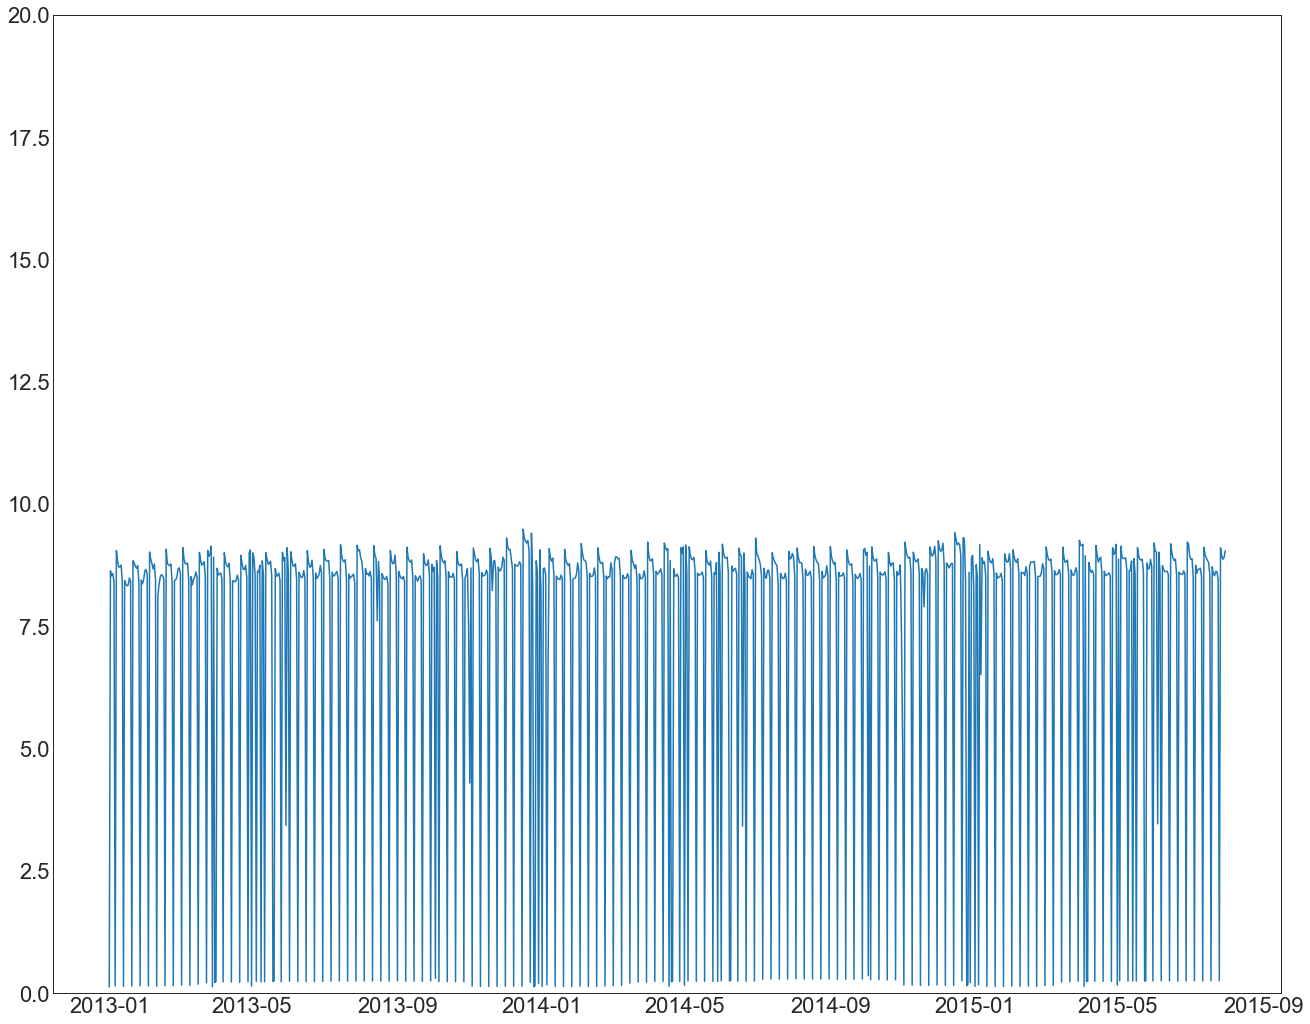

In [77]:
daily_log_sales = df_train.groupby(['Date'])['log_sales'].mean().reset_index()
plt.plot('Date',
         'log_sales',
         data=daily_log_sales)
plt.ylim(0, 20)

### Feature Engineering

### Model Prediction